In [11]:
import pandas as pd

df = pd.read_csv('nyc_taxi_trip_duration.csv')
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848


In [14]:
import datetime as dt


def convert_to_datetime(date):
    return dt.datetime.strptime(date, '%Y-%m-%d %H:%M:%S')

In [17]:
df['date'] = df.apply(lambda row: convert_to_datetime(row['pickup_datetime']), axis=1)

In [56]:
df['day'] = df.apply(lambda row: int(row['date'].strftime('%j')), axis=1)
df['month'] = df.apply(lambda row: row['date'].strftime('%b %Y'), axis=1)
days_trips = df.groupby(['day', 'month']).agg(amount_of_trips=('trip_duration', 'count')).reset_index()
days_trips.head()

,day,month,amount_of_trips
0,1,Jan 2016,3588
1,2,Jan 2016,3228
2,3,Jan 2016,3158
3,4,Jan 2016,3341
4,5,Jan 2016,3595


In [60]:
from sklearn.ensemble import IsolationForest

anomaly_inputs = ['amount_of_trips', 'day']

model = IsolationForest(contamination=0.1, random_state=42)
model.fit(days_trips[anomaly_inputs])

IsolationForest(contamination=0.1, random_state=42)

In [61]:
days_trips['anomaly_score'] = model.decision_function(days_trips[anomaly_inputs])
days_trips['anomaly'] = model.predict(days_trips[anomaly_inputs])

In [70]:
months = days_trips.groupby(['month']).agg(max_day=('day', 'max')).reset_index()
months.head()

,month,max_day
0,Apr 2016,121
1,Feb 2016,60
2,Jan 2016,31
3,Jun 2016,182
4,Mar 2016,91


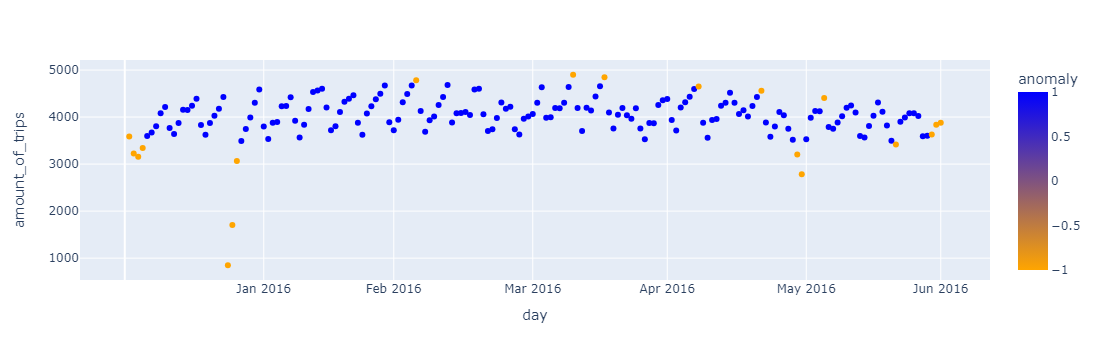

In [73]:
import plotly.express as px
import numpy as np

fig = px.scatter(days_trips, x='day', y='amount_of_trips', color='anomaly', color_continuous_scale=['orange', 'blue'])
fig.update_layout(
    xaxis=dict(
        tickmode = 'array',
        tickvals = months['max_day'],
        ticktext = months['month'],
    )
)
fig.show()


In [78]:
days_travel = df.groupby(['day', 'month']).agg(trips_time=('trip_duration', 'sum')).reset_index()
days_travel.head()

,day,month,trips_time
0,1,Jan 2016,3445026
1,2,Jan 2016,2921370
2,3,Jan 2016,3007117
3,4,Jan 2016,2704992
4,5,Jan 2016,5314207


In [81]:
anomaly_inputs = ['day', 'trips_time']
model.fit(days_travel[anomaly_inputs])

days_travel['anomaly_score'] = model.decision_function(days_travel[anomaly_inputs])
days_travel['anomaly'] = model.predict(days_travel[anomaly_inputs])

In [82]:
months = days_travel.groupby(['month']).agg(max_day=('day', 'max')).reset_index()
months.head()

,month,max_day
0,Apr 2016,121
1,Feb 2016,60
2,Jan 2016,31
3,Jun 2016,182
4,Mar 2016,91


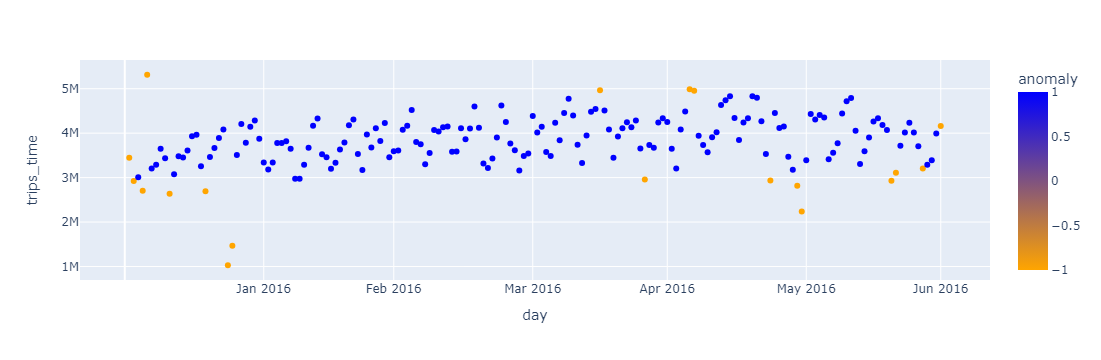

In [83]:
fig = px.scatter(days_travel, x='day', y='trips_time', color='anomaly', color_continuous_scale=['orange', 'blue'])
fig.update_layout(
    xaxis=dict(
        tickmode = 'array',
        tickvals = months['max_day'],
        ticktext = months['month'],
    )
)
fig.show()

In [90]:
from math import cos, radians


def distance(longitude1, latitude1, longitude2, latitude2):
  degree_kilometres = 111.2
  latitude_dif = degree_kilometres * abs(latitude2 - latitude1)
  longitude_dif = abs(longitude1 - longitude2)
  AD = degree_kilometres * cos(radians(latitude1)) * longitude_dif
  BC = degree_kilometres * cos(radians(latitude2)) * longitude_dif
  temp = (AD - BC) / 2
  H = (latitude_dif ** 2 - temp ** 2) ** 0.5
  return ((max(AD, BC) - temp) ** 2 + H ** 2) ** 0.5 * 1000

In [93]:
df['distance'] = df.apply(lambda row: distance(
    row['pickup_longitude'],
    row['pickup_latitude'],
    row['dropoff_longitude'],
    row['dropoff_latitude'],
), axis=1)

days_distance = df.groupby(['day', 'month']).agg(distance=('distance', 'sum')).reset_index()
days_distance.head()

,day,month,distance
0,1,Jan 2016,1.398361e+07
1,2,Jan 2016,1.137555e+07
2,3,Jan 2016,1.264087e+07
3,4,Jan 2016,1.152006e+07
4,5,Jan 2016,1.172673e+07


In [94]:
anomaly_inputs = ['day', 'distance']
model.fit(days_distance[anomaly_inputs])

days_distance['anomaly_score'] = model.decision_function(days_distance[anomaly_inputs])
days_distance['anomaly'] = model.predict(days_distance[anomaly_inputs])

In [95]:
months = days_distance.groupby(['month']).agg(max_day=('day', 'max')).reset_index()
months.head()

,month,max_day
0,Apr 2016,121
1,Feb 2016,60
2,Jan 2016,31
3,Jun 2016,182
4,Mar 2016,91


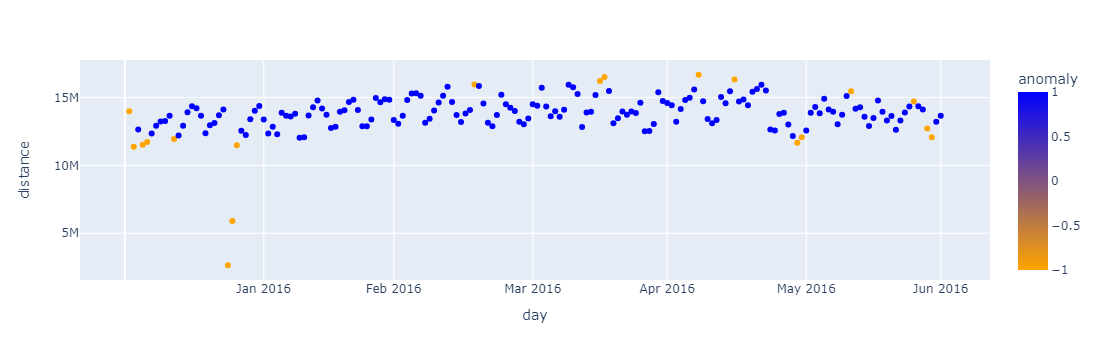

In [99]:
fig = px.scatter(days_distance, x='day', y='distance', color='anomaly', color_continuous_scale=['orange', 'blue'])
fig.update_layout(
    xaxis=dict(
        tickmode = 'array',
        tickvals = months['max_day'],
        ticktext = months['month'],
    )
)
fig.show()